# Flowers Classification Project

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import image_dataset_from_directory
import urllib.request
import tarfile
import os
import zipfile
import urllib.request


tf.random.set_seed(42)
np.random.seed(42)


IMG_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3
L2_FACTOR = 0.0001

In [ ]:

# URL to a ZIP file
url = 'http://download.tensorflow.org/example_images/flower_photos.tgz';
zip_path = "flower_photos.tgz"

# Download the file
urllib.request.urlretrieve(url, zip_path)

# Extract the tar file
import tarfile
with tarfile.open(zip_path, "r:gz") as tar:
    tar.extractall()

# Set the path to the extracted folder
data_dir = "flower_photos"


## Data Augmentation

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

## Load and Preprocess Dataset

In [ ]:
# Load full dataset (100%)
full_ds = image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True  # Important for random splitting
)

# Get class names
class_names = full_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Count number of batches in full dataset
dataset_size = 0
for _ in full_ds:
    dataset_size += 1

# Calculate split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# Split the dataset
train_ds = full_ds.take(train_size)
remaining = full_ds.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

# Preprocessing function
def preprocess_image(image, label, training=False):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    if training:
        image = data_augmentation(image)
    image = image / 255.0
    return image, label

train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, training=True)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: preprocess_image(x, y, training=False)).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, training=False)).cache().prefetch(tf.data.AUTOTUNE)



Found 3670 files belonging to 5 classes.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize Sample Images

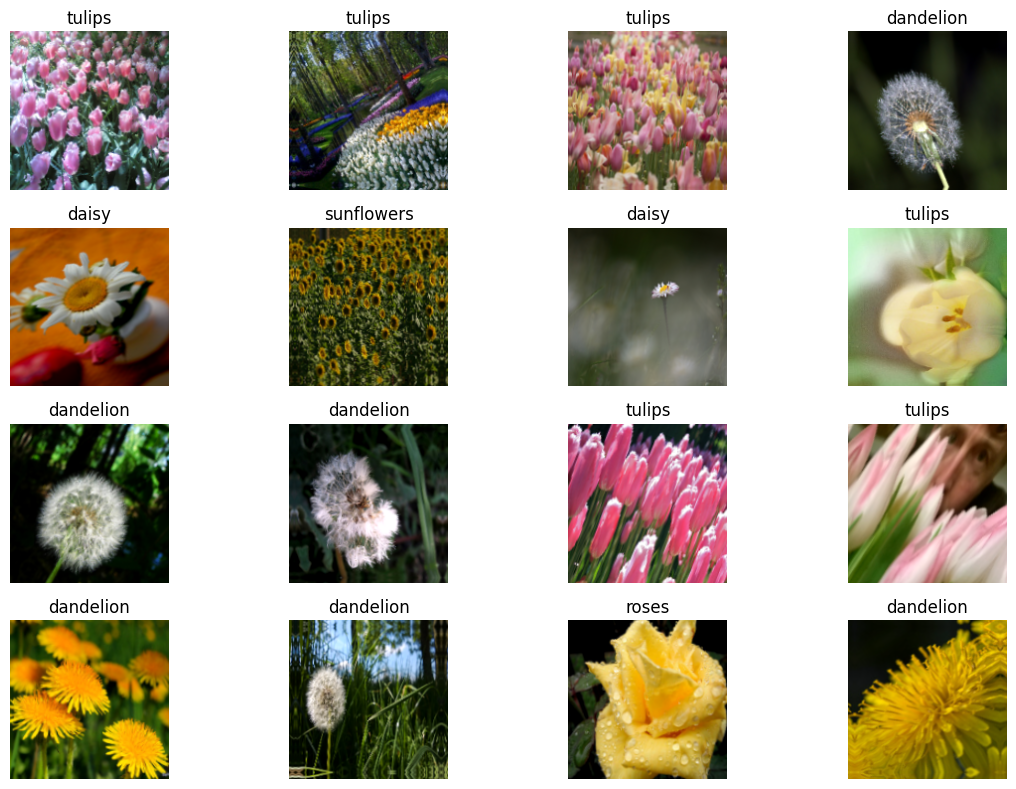

In [ ]:
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.tight_layout()
plt.show()

### Class Distribution

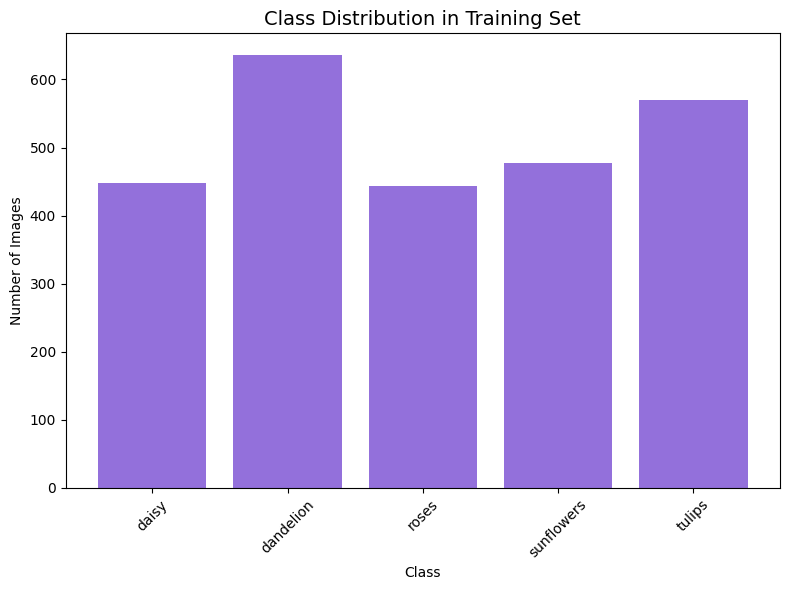

In [ ]:
class_counts = [0] * len(class_names)

for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1

plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color='mediumpurple')
plt.title("Class Distribution in Training Set", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Mean and Std of Pixel Values

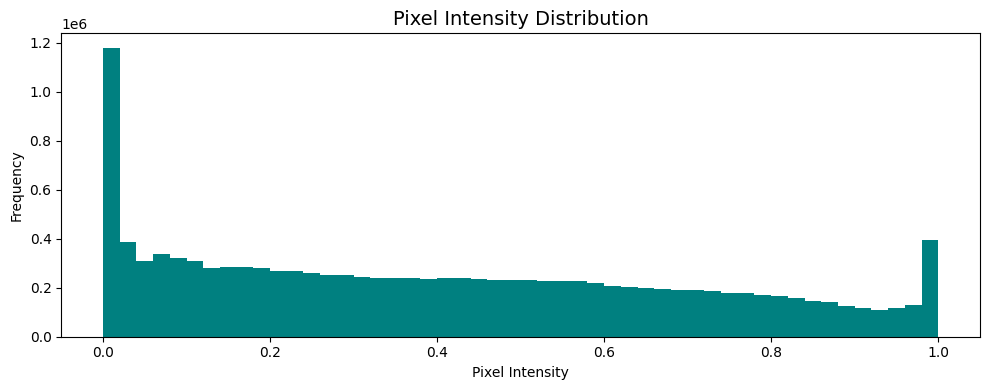

In [ ]:
import numpy as np

all_pixels = []

for images, _ in train_ds.take(10):  # just sample some batches
    all_pixels.append(images.numpy())

pixels = np.concatenate(all_pixels).ravel()

plt.figure(figsize=(10, 4))
plt.hist(pixels, bins=50, color='teal')
plt.title("Pixel Intensity Distribution", fontsize=14)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Model 1 - Custom CNN

### Build and compile

In [ ]:
cnn_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,877 (93.27 KB)

 Trainable params: 23,877 (93.27 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('custom_cnn_best.keras', save_best_only=True)
]

history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - accuracy: 0.3198 - loss: 1.5065 - val_accuracy: 0.3915 - val_loss: 1.2957
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 93s 575ms/step - accuracy: 0.4340 - loss: 1.2599 - val_accuracy: 0.4559 - val_loss: 1.2938
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 528ms/step - accuracy: 0.4822 - loss: 1.1924 - val_accuracy: 0.4485 - val_loss: 1.2310
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 159s 630ms/step - accuracy: 0.5058 - loss: 1.1702 - val_accuracy: 0.4871 - val_loss: 1.2264
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 87s 541ms/step - accuracy: 0.5267 - loss: 1.1692 - val_accuracy: 0.4908 - val_loss: 1.1676
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 90s 557ms/step - accuracy: 0.5636 - loss: 1.1058 - val_accuracy: 0.5239 - val_loss: 1.1321
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 501ms/step - accuracy: 0.5691 - loss: 1.0639 - val_accuracy: 0.5129 - val_loss: 1.1403
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 513ms/step - accuracy: 0.5938 - loss:

### Plot Training History

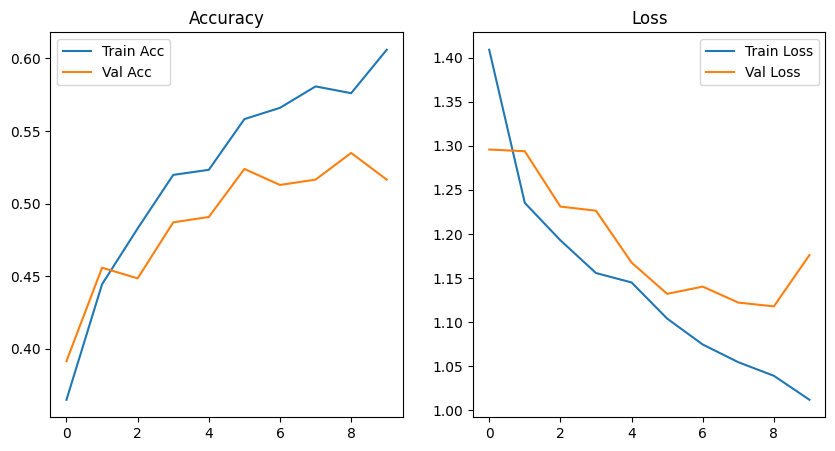

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


### Evaluation

In [ ]:
#evaluation on test set
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss_cnn)
print("Test Accuracy:", test_accuracy_cnn)

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.5617 - loss: 1.0757
Test Loss: 1.0780293941497803
Test Accuracy: 0.5563636422157288


In [ ]:
#evaluation on training set
train_loss_cnn, train_accuracy_cnn = cnn_model.evaluate(train_ds)
print("Train Loss:", train_loss_cnn)
print("Train Accuracy:", train_accuracy_cnn)

161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.6085 - loss: 1.0021
Train Loss: 0.9919695854187012
Train Accuracy: 0.616847813129425


In [ ]:
#Prediction
y_pred, y_true = [], []
for images, labels in test_ds:
    preds = cnn_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

#Classification
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Model 2 - MobileNetV2

### Build and compile

In [ ]:
base_netv2_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_netv2_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_netv2_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR))(x)
x = layers.Dropout(DROPOUT_RATE)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

netv2_model = tf.keras.Model(inputs, outputs)

netv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

netv2_model.summary()



### Training

In [ ]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_best.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
]

history_netv2 = netv2_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


### Plot Training History

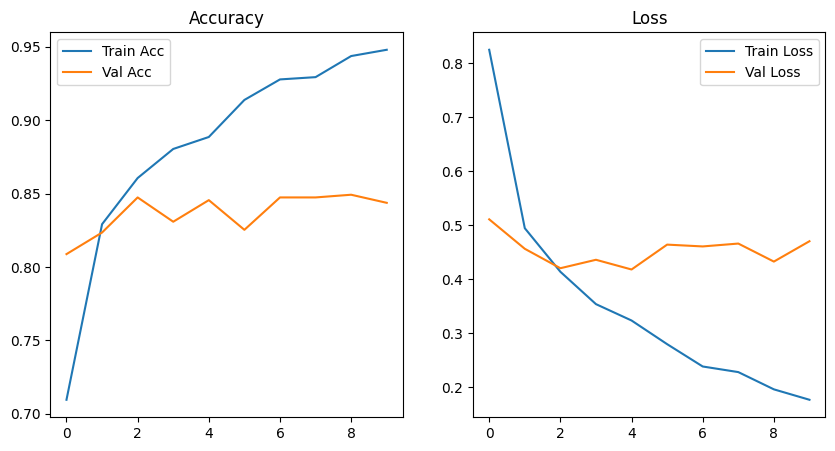

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_netv2.history['accuracy'], label='Train Acc')
plt.plot(history_netv2.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_netv2.history['loss'], label='Train Loss')
plt.plot(history_netv2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Evaluation

In [ ]:
# Evaluation on test set for MobileNetV2
test_loss_netv2, test_accuracy_netv2 = netv2_model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss_netv2)
print("Test Accuracy:", test_accuracy_netv2)


In [ ]:
# Evaluation on training set
train_loss_netv2, train_accuracy_netv2 = netv2_model.evaluate(train_ds)
print("Train Loss:", train_loss_netv2)
print("Train Accuracy:", train_accuracy_netv2)

In [ ]:
#Prediction
y_pred, y_true = [], []
for images, labels in test_ds:
    preds = netv2_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

#Classification
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Model 3 - Model 1 + Batch Normalization, Kernel Regularization, Early Stopping


### Build and compile

In [ ]:
cnn2_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dropout(DROPOUT_RATE),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)),

    layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(L2_FACTOR))
])

cnn2_model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn2_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,261 (94.77 KB)

 Trainable params: 24,069 (94.02 KB)

 Non-trainable params: 192 (768.00 B)

### Training

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('custom_cnn_best.keras', save_best_only=True, monitor='val_loss')
]

history_cnn2 = cnn2_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 144s 882ms/step - accuracy: 0.4014 - loss: 1.4151 - val_accuracy: 0.2408 - val_loss: 1.6714
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 199s 866ms/step - accuracy: 0.5214 - loss: 1.2007 - val_accuracy: 0.2831 - val_loss: 1.7183
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 146s 905ms/step - accuracy: 0.5414 - loss: 1.1590 - val_accuracy: 0.4504 - val_loss: 1.3134
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 201s 899ms/step - accuracy: 0.5493 - loss: 1.1517 - val_accuracy: 0.5276 - val_loss: 1.1354
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 139s 862ms/step - accuracy: 0.5331 - loss: 1.1494 - val_accuracy: 0.4430 - val_loss: 1.5828
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 141s 878ms/step - accuracy: 0.5668 - loss: 1.1026 - val_accuracy: 0.4779 - val_loss: 1.2597
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 141s 873ms/step - accuracy: 0.5916 - loss: 1.0579 - val_accuracy: 0.4338 - val_loss: 1.5680
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 138s 852ms/step - accuracy: 0.5714 -

### Plot Training History

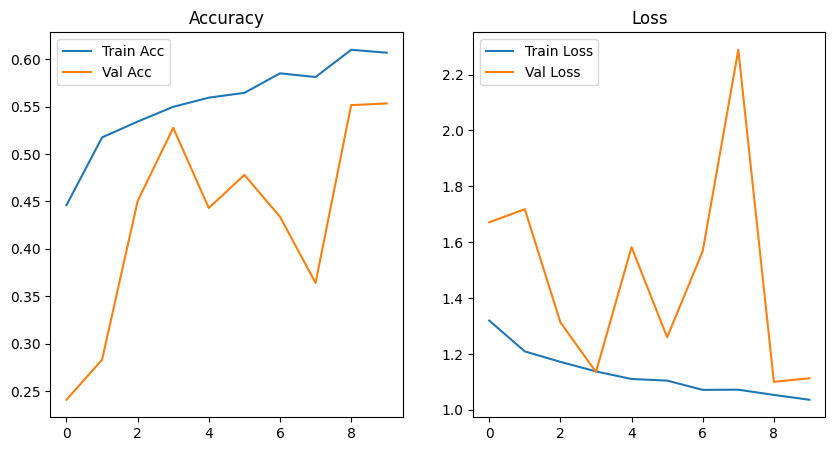

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['accuracy'], label='Train Acc')
plt.plot(history_cnn2.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['loss'], label='Train Loss')
plt.plot(history_cnn2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Evaluation

In [ ]:
#evaluation on test set
test_loss_cnn2, test_accuracy_cnn2 = cnn2_model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss_cnn2)
print("Test Accuracy:", test_accuracy_cnn2)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5963 - loss: 1.0653
Test Loss: 1.060550570487976
Test Accuracy: 0.5945454835891724


In [ ]:
#evaluation on training set
train_loss_cnn2, train_accuracy_cnn2 = cnn2_model.evaluate(train_ds)
print("Train Loss:", train_loss_cnn2)
print("Train Accuracy:", train_accuracy_cnn2)

161/161 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.6234 - loss: 0.9595
Train Loss: 0.9601622223854065
Train Accuracy: 0.6269409656524658


In [ ]:
#Prediction
y_pred, y_true = [], []
for images, labels in test_ds:
    preds = cnn2_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

#Classification
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Model 4 - Model 3 + Tuned DROPOUT_RATE, L2_FACTOR and LEARNING_RATE

### Build and compile

In [ ]:
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.4
L2_FACTOR = 0.001

cnn3_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dropout(DROPOUT_RATE),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)),

    layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(L2_FACTOR))
])

cnn3_model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn3_model.summary()

### Training

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('custom_cnn_best.keras', save_best_only=True, monitor='val_loss')
]

history_cnn3 = cnn3_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

### Plot Training History

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn3.history['accuracy'], label='Train Acc')
plt.plot(history_cnn3.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_cnn3.history['loss'], label='Train Loss')
plt.plot(history_cnn3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

### Evaluation

In [ ]:
#evaluation on test set
test_loss_cnn3, test_accuracy_cnn3 = cnn3_model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss_cnn3)
print("Test Accuracy:", test_accuracy_cnn3)

In [ ]:
#evaluation on training set
train_loss_cnn3, train_accuracy_cnn3 = cnn3_model.evaluate(train_ds)
print("Train Loss:", train_loss_cnn3)
print("Train Accuracy:", train_accuracy_cnn3)

In [ ]:
#Prediction
y_pred, y_true = [], []
for images, labels in test_ds:
    preds = cnn3_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

#Classification
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Comparison

In [ ]:
def plot_comparison(history1, name1, history2, name2):
    epochs = range(1, len(history1.history['accuracy']) + 1)

    plt.figure(figsize=(8, 4))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history1.history['accuracy'], 'b-', label=f'{name1} Train Acc')
    plt.plot(epochs, history1.history['val_accuracy'], 'b--', label=f'{name1} Val Acc')
    plt.plot(epochs, history2.history['accuracy'], 'r-', label=f'{name2} Train Acc')
    plt.plot(epochs, history2.history['val_accuracy'], 'r--', label=f'{name2} Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize=8)
    plt.grid(True)

    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history1.history['loss'], 'b-', label=f'{name1} Train Loss')
    plt.plot(epochs, history1.history['val_loss'], 'b--', label=f'{name1} Val Loss')
    plt.plot(epochs, history2.history['loss'], 'r-', label=f'{name2} Train Loss')
    plt.plot(epochs, history2.history['val_loss'], 'r--', label=f'{name2} Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize=8)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_accuracy_loss_comparison(model_names, test_accuracies, test_losses, figsize=(6,4)):

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=figsize)

    bars_acc = ax1.bar(x - width/2, test_accuracies, width, label='Test Accuracy', color='teal')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    bars_loss = ax2.bar(x + width/2, test_losses, width, label='Test Loss', color='darkblue')
    ax2.set_ylabel('Test Loss')
    ax2.set_ylim(0, max(test_losses) * 1.1)
    ax2.legend(loc='upper right')

    def add_values(bars, axis):
        for bar in bars:
            h = bar.get_height()
            axis.annotate(f'{h:.2f}',
                          xy=(bar.get_x() + bar.get_width()/2, h),
                          xytext=(0, 3),
                          textcoords='offset points',
                          ha='center', va='bottom',
                          fontsize=9)

    add_values(bars_acc, ax1)
    add_values(bars_loss, ax2)

    plt.title('Test Accuracy and Loss Comparison')
    plt.tight_layout()
    plt.show()

### Model 1 and Model 2

In [ ]:
# Labels for the models
names = ['Custom CNN', 'MobileNetV2']

# Accuracy and Loss values
accuracy = [test_accuracy_cnn, test_accuracy_netv2]
loss = [test_loss_cnn, test_loss_netv2]

plot_comparison(history_cnn, "Custom CNN", history_netv2, "MobileNetV2")
plot_accuracy_loss_comparison(names, accuracy, loss)


### Model 3 and Model 4


In [ ]:
# Labels for the models
names = ['Model 3', 'Model 4']

# Accuracy and Loss values
accuracy = [test_accuracy_cnn2, test_accuracy_cnn3]
loss = [test_loss_cnn2, test_loss_cnn3]

plot_comparison(history_cnn2, "Model 3", history_cnn3, "Model 4")
plot_accuracy_loss_comparison(names, accuracy, loss)